## Read Files

In [132]:
import pandas as pd
import os

# Files to use for the analysis

data_folder = os.path.join("../data")
raw_results = os.path.join("../results/raw-results")
results_folder = os.path.join("../results")
fig_folder = os.path.join("../results/plots")

projects_ranking_file = os.path.join(data_folder, 'jmh-projects-bigquery-201702.csv')

top = 25

projects = pd.read_csv(projects_ranking_file, sep=',')


# Normalize columns
projects['xml'] = projects['project'].apply(lambda x: x.split('/')[1] + '.xml')
projects['name'] = projects['project'].apply(lambda x: x.split('/')[1])


In [110]:
# Normalizing the plot colors
COLOR = 'lightskyblue'
ALPHA = .8

## Remove Projects that could not be analyzed

In [111]:
# Remove projects that could not be analyzed
projects_to_remove = ['jgrapht/jgrapht', 'lemire/RoaringBitmap', 'RoaringBitmap/RoaringBitmap', 
                      'requery/requery', 'Netflix/feign', 'crate/crate', 'real-logic/simple-binary-encoding', 
                      'jbachorik/btrace', 'promeG/TinyPinyin', 'pcollections/pcollections', 'ktoso/sbt-jmh', 
                      'junkdog/artemis-odb', 'fakemongo/fongo', 'graalvm/truffle', 'graalvm/graal-core']

projects = projects[~projects['project'].isin(projects_to_remove)] # jgrapht

top_projects = projects.sort_values(by=['watchers', 'stars', 'forks'], ascending=False)

### Remove Forked Projects

In [112]:
non_duplicated_projects = top_projects[top_projects.forked == False]
print('Original Set containing %d projects' % len(top_projects))
print('Non-forked projects containing %d projects' % len(non_duplicated_projects))

Original Set containing 824 projects
Non-forked projects containing 506 projects


## Analyze the bugs based on the Type reported

In [113]:
from collections import Counter
import xml.etree.ElementTree as ET

def analyzeBugTypes(df):
    
    try:
    
        tree = ET.parse(os.path.join(raw_results, df['xml']))
        root = tree.getroot()

        all_bugs = root.findall('BugInstance')

        bugs_per_type = [] 
        for b in all_bugs:
            bug_type = b.get('type')
            clazz = b.find('Class')
            if clazz and 'generated' not in clazz.get('classname'):
                bugs_per_type.append(bug_type)

        # Count bugs per type
        bugs = Counter(bugs_per_type)
        for key, value in bugs.items():
            df[key] = value
    
    except FileNotFoundError:
        pass
    
    return df

analyzed = non_duplicated_projects.apply(analyzeBugTypes, axis=1)
analyzed = analyzed.fillna(0)
analyzed = analyzed.set_index('name')
analyzed = analyzed[analyzed['JMH_BENCHMARK_METHOD_FOUND'] > 0]

columns_to_export = [
   'stars',
   'forks',
    'subscribers',
    'watchers',
    'JMH_BENCHMARK_METHOD_FOUND',
    'JMH_FIXTURE_USING_INVOCATION_SCOPE',
    'JMH_NOTFORKED_BENCHMARK',
    'JMH_DEAD_STORE_VARIABLE',
    'JMH_IGNORED_STATIC_METHOD_RETURN',
    'JMH_IGNORED_STATIC_PRIMITIVE_METHOD_RETURN',
    'JMH_STATE_FINAL_PRIMITIVE',
    'JMH_UNSAFELOOP_INSIDE_BENCHMARK',
]


bug_type_dict = {
    'stars': 'Stars',
    'forks': 'Forks',
    'subscribers': 'Subs',
    'JMH_BENCHMARK_METHOD_FOUND': 'Benchs',
    'JMH_FIXTURE_USING_INVOCATION_SCOPE': 'INVO',
    'JMH_IGNORED_METHOD_RETURN': 'RETU',
    'JMH_UNSAFELOOP_INSIDE_BENCHMARK': 'LOOP',
    'JMH_STATE_FINAL_FIELD': 'FINA',
    'JMH_NOTFORKED_BENCHMARK': 'FORK',
    'JMH_DEAD_STORE_VARIABLE': 'DEAD',
    'JMH_IGNORED_STATIC_METHOD_RETURN': 'STAT',
    'JMH_IGNORED_STATIC_PRIMITIVE_METHOD_RETURN': 'STAT2',
    
    'JMH_STATE_FINAL_PRIMITIVE': 'FINA',
    
}

analyzed = analyzed[columns_to_export]
analyzed = analyzed.rename(columns=bug_type_dict)


### Droping some duplicates

For some reasons our set contains some projects multiple times.

In [114]:
analyzed = analyzed.sort_values(by='Stars', ascending=False)
print(len(analyzed))

print("Removing the following projects")
print(analyzed[analyzed.index.duplicated(keep='first')].index)

# Remove the one with least amount of stars
analyzed = analyzed[~analyzed.index.duplicated(keep='first')]
print(len(analyzed))


133
Removing the following projects
Index(['javaslang-circuitbreaker', 'rapidpm-microservice', 'netty',
       'microbenchmarks', 'java', 'java', 'microbenchmarks', 'rtree',
       'airlift', 'microbenchmarks'],
      dtype='object', name='name')
123


# Dataset Exploration 

### Stars

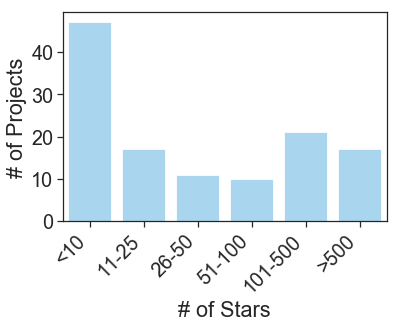

In [115]:
import seaborn as sns
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

sns.set(font_scale=1.8)
plt.figure(figsize=(6,5))
sns.set_style("ticks")

starbins=[0,10,25,50,100,500,50000]

stars = pd.cut(analyzed['Stars'], bins=starbins).value_counts()
ax = sns.barplot(x=stars.index, y=stars, color=COLOR, alpha=ALPHA)

ax.set_xticklabels(['<10', '11-25','26-50','51-100','101-500','>500'], rotation = 45, ha="right")
# , rotation = 45, ha="right"
ax.set(xlabel='# of Stars', ylabel='# of Projects')

plt.tight_layout()
#plt.savefig(os.path.join(fig_folder, 'projects-stars-distribution.pdf'))
#plt.close()

### Forks

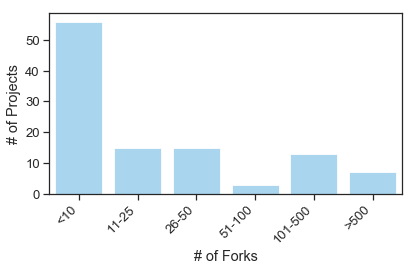

In [116]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.set_style("ticks")

forksbin=[0,10,25,50,100,500,50000]

forks = pd.cut(analyzed['Forks'], bins=forksbin).value_counts()
ax = sns.barplot(x=forks.index, y=forks, color=COLOR, alpha=ALPHA)

ax.set_xticklabels(['<10', '11-25','26-50','51-100','101-500','>500'], rotation = 45, ha="right")
ax.set(xlabel='# of Forks', ylabel='# of Projects')

plt.tight_layout()
#plt.savefig(os.path.join(fig_folder, 'projects-forks-distribution.pdf'))
#plt.close()

### Subscribers

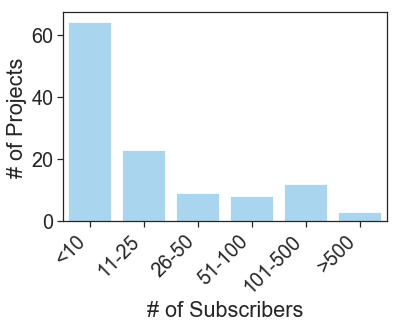

In [117]:
sns.set(font_scale=1.8)
plt.figure(figsize=(6,5))
sns.set_style("ticks")

subscribersbin=[0,10,25,50,100,500,50000]

subs = pd.cut(analyzed['Subs'], bins=subscribersbin).value_counts()
ax = sns.barplot(x=subs.index, y=subs, color=COLOR, alpha=ALPHA)

ax.set_xticklabels(['<10', '11-25','26-50','51-100','101-500','>500'], rotation = 45, ha="right")
ax.set(xlabel='# of Subscribers', ylabel='# of Projects')

plt.tight_layout()
#plt.savefig(os.path.join(fig_folder, 'projects-subscribers-distribution.pdf'))
#plt.close()

### Consolidate RETU anti-pattern

In [118]:
analyzed['RETU'] = analyzed['DEAD'] + analyzed['STAT2'] + analyzed['STAT']

## Latex Table - By Amount of Benchmarks

In [127]:
latex = analyzed.copy()

pd.options.display.float_format = '{:.0f}'.format


latex = latex.sort_values(by='Benchs', ascending=False)

latex = latex[:25]
latex = latex.fillna('')
latex = latex.replace({0: ''})

order = ['Stars', 'Benchs', 'RETU', 'LOOP', 'FINA', 'INVO', 'FORK']

print(latex[order].to_latex())

\begin{tabular}{llllllll}
\toprule
{} &  Stars & Benchs & RETU & LOOP & FINA & INVO & FORK \\
name                                &        &        &      &      &      &      &      \\
\midrule
gs-collections                      &   1652 &    451 &   47 &      &      &      &      \\
logging-log4j2                      &    256 &    346 &    5 &    7 &    5 &      &      \\
RxJava                              &  23558 &    215 &      &      &      &      &      \\
oopsla15-artifact                   &     16 &    213 &    4 &    1 &    2 &   12 &    3 \\
netty                               &   9746 &    159 &    2 &   14 &    2 &    2 &      \\
reactive-streams-commons            &    106 &    157 &    2 &      &      &      &      \\
druid                               &   4743 &    148 &      &    8 &    2 &    2 &      \\
JCTools                             &   1053 &     92 &      &    1 &      &    2 &      \\
golo-jmh-benchmarks                 &      4 &     92 &      &      &

### Latex (Full Table)

In [133]:
latex = analyzed.copy()

pd.options.display.float_format = '{:.0f}'.format


latex = latex.sort_values(by='Benchs', ascending=False)

latex = latex.fillna('')
latex = latex.replace({0: ''})

order = ['Stars', 'Benchs', 'RETU', 'LOOP', 'FINA', 'INVO', 'FORK']

latex[order].to_csv(os.path.join(results_folder, 'bad-jmh-practices-occurrence.csv'))

In [120]:
anti_patterns = ['INVO', 'FORK', 'RETU', 'FINA', 'LOOP']

def anti_pattern_category_analysis(df):
    cat = 0
    count = 0
    for ap in anti_patterns:
        if df[ap] > 0:
            cat = cat + 1
            count = count + df[ap]
    df['# of AP'] = count
    df['# of Categories'] = cat
    return df
    
df = analyzed.apply(anti_pattern_category_analysis, axis=1)
print('Analyzed Projects containing %d' % len(df))

Analyzed Projects containing 123


### Project Distribution Analysis

Anti-patterns category distribution across different projects.

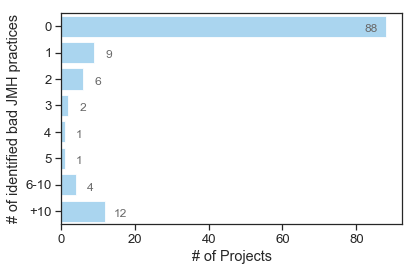

In [121]:
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("ticks")

bins = [-1,0,1,2,3,4,5,10,50]

plt.figure(figsize=(6,4))

clrs = 'colorblind'
clrs = 'Blues'

distribution = pd.cut(df['# of AP'], bins=bins).value_counts()
#distribution = distribution / 123 * 100
distribution = distribution[distribution > 0]
ax = sns.barplot(y=distribution.index, x=distribution, color=COLOR, alpha=ALPHA)

for p in ax.patches:
    if p.get_width() > 40:
        offset = -4
    else:
        offset = +4
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width() + offset, p.get_y() + .5),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars

ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6-10','+10']))
ax.set(ylabel='# of identified bad JMH practices', xlabel='# of Projects',)

plt.tight_layout()
#plt.savefig(os.path.join(fig_folder, 'projects-ap-ditribution.pdf'))

### With Large Benchmark Suites

In [122]:
large_df = df[df.Benchs >= 10]
len(large_df)

49

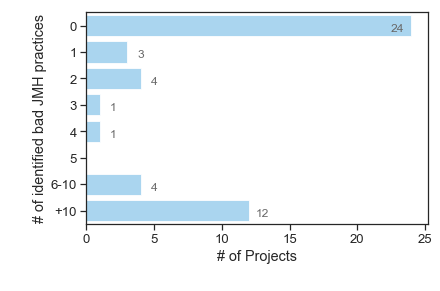

In [123]:
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("ticks")

bins = [-1,0,1,2,3,4,5,10,50]

plt.figure(figsize=(6,4))

clrs = 'colorblind'
clrs = 'Blues'

distribution = pd.cut(large_df['# of AP'], bins=bins).value_counts()
#distribution = distribution / 123 * 100
distribution = distribution[distribution > 0]
ax = sns.barplot(y=distribution.index, x=distribution, color=COLOR, alpha=ALPHA)

for p in ax.patches:
    if p.get_width() > 20:
        offset = -1
    else:
        offset = +1
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width() + offset, p.get_y() + .5),
         ha='center', va='center', rotation=0, xytext=(0, 0), textcoords='offset points',fontsize=12, color='dimgray')  #vertical bars

ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0','1','2','3','4','5','6-10','+10']))
ax.set(ylabel='# of identified bad JMH practices', xlabel='# of Projects',)

plt.tight_layout()
#plt.savefig(os.path.join(fig_folder, 'projects-ap-ditribution-large.pdf'))

### Analysis per Category of Anti-pattern

In [124]:
category_df = pd.DataFrame(columns=['Total', '# of Projects'])

pd.options.display.float_format = '{:.2f}'.format

for ap in anti_patterns:
    total = df[ap].sum()
    projects = len(df[df[ap] > 0])
    category_df.loc[ap] = [total, projects]
    
category_df['% of Projects'] = category_df['# of Projects'] / len(df) * 100

print(category_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Total &  \# of Projects &  \% of Projects \\
\midrule
INVO &  83.00 &          10.00 &           8.13 \\
FORK &   7.00 &           3.00 &           2.44 \\
RETU &  77.00 &          15.00 &          12.20 \\
FINA &  27.00 &           9.00 &           7.32 \\
LOOP & 126.00 &          16.00 &          13.01 \\
\bottomrule
\end{tabular}



### Selected Projects

In [125]:
selected = pd.DataFrame(columns=['#1', '#2', '#3'])

for ap in anti_patterns: 
    p = analyzed[analyzed[ap] > 1] # Filter unique cases
    selected.loc[ap] = p[:3].index.values
    
print(selected.to_latex())

\begin{tabular}{llll}
\toprule
{} &      \#1 &                 \#2 &                   \#3 \\
\midrule
INVO &   netty &              druid &                h2o-3 \\
FORK &  pgjdbc &  oopsla15-artifact &  benchmark-arraycopy \\
RETU &   netty &     gs-collections &       logging-log4j2 \\
FINA &   netty &              druid &       logging-log4j2 \\
LOOP &   netty &              druid &                h2o-3 \\
\bottomrule
\end{tabular}



### Correlation between # Benchmarks and Amount of Antipatterns found

(0.6734990915436911, 1.4012156309647174e-17)

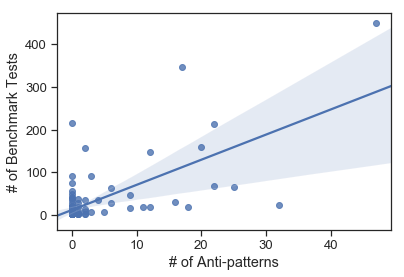

In [126]:
from scipy import stats

all_antipatterns = ['INVO', 'FORK', 'RETU', 'LOOP', 'FINA']

df['# of Anti-patterns'] = df[all_antipatterns].apply(sum, axis=1)

ax = sns.regplot(x="# of Anti-patterns", y="Benchs", data=df)
ax.set(xlabel='# of Anti-patterns', ylabel='# of Benchmark Tests')
#plt.savefig(os.path.join(fig_folder, '..', 'figs', 'correlation-bench-ap.pdf'))

stats.pearsonr(df['Benchs'].values, df['# of Anti-patterns'].values)